# Single-Cell RNA Seq Example

## Outline

- [Setup](#setup)
- [Understanding the mechanism of action of a drug using causal inference](#understanding-the-mechanism-of-action-of-a-drug-using-causal-inference)
    - [Data Source](#data-source)
    - [Goal: Understand the effects that the cancer drug candidate Panobinostat LBH589 has on the HDAC pathway](#goal-understand-the-effects-that-the-cancer-drug-candidate-panobinostat-lbh589-has-on-the-hdac-pathway)
- [Causal Probabilistic Program](#causal-probabilistic-program)
    - [Model Description](#model-description)
    - [Reporting regression coefficients](#reporting-regression-coefficients)
    - [Predictions on unseen cells](#predictions-on-unseen-cells)
- [Computing causal queries](#computing-causal-queries)
    - [Imputing potential outcomes](#imputing-potential-outcomes)
    - [Causal Query: Average treatment effect (ATE)](#causal-query-average-treatment-effect-ate)
    - [Causal Query: Conditional average treatment effect (CATE)](#causal-query-conditional-average-treatment-effect-cate)
- [References](#references)





## Setup

Here, we install the necessary Pytorch, Pyro, and ChiRho dependencies for this example.

In [19]:
import os
import math
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
from pyro.infer.autoguide import AutoNormal
from pyro.nn import PyroModule
import pyro.distributions as dist
import torch

from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather
from chirho.interventional.handlers import do
from chirho.observational.handlers import condition

pyro.clear_param_store()
pyro.set_rng_seed(1234)
pyro.settings.set(module_local_params=True)

sns.set_style("white")

## Understanding the mechanism of action of a drug using causal inference

### Data Source

We analyze the SciPlex3 dataset from [3], which consists of over 650K single-cell measurements (`X`) for three different cancer cell types (`cell_type`): MCF7, K562, and A549. Each cell in this dataset is unperturbed (`Vehicle`) or randomly treated with a drug from a library of 188 drug perburbations (`product_name`) at 4 different dosages (`dose`): $10^1, 10^2, 10^3, 10^4$ nM.

In [2]:
# Download raw data if doesn't already exist
if not os.path.exists("SrivatsanTrapnell2020_sciplex3_debugged.h5"):
    # Download and unzip 3 files files from here:
    # https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4150378
    # (1) GSM4150378_sciPlex3_A549_MCF7_K562_screen_UMI.count.matrix.gz
    # (2) GSM4150378_sciPlex3_A549_MCF7_K562_screen_gene.annotations.txt.gz
    # (3) GSM4150378_sciPlex3_pData.txt.gz

    # Cach raw zip files
    os.system(
        "wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4150nnn/GSM4150378/suppl/GSM4150378_sciPlex3_A549_MCF7_K562_screen_UMI.count.matrix.gz"
    )
    os.system(
        "wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4150nnn/GSM4150378/suppl/GSM4150378_sciPlex3_A549_MCF7_K562_screen_gene.annotations.txt.gz"
    )

    os.system(
        "wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4150nnn/GSM4150378/suppl/GSM4150378_sciPlex3_pData.txt.gz"
    )

    # unzip files
    os.system("gunzip GSM4150378_sciPlex3_A549_MCF7_K562_screen_UMI.count.matrix.gz")
    os.system("gunzip GSM4150378_sciPlex3_A549_MCF7_K562_screen_gene.annotations.txt.gz")
    os.system("gunzip GSM4150378_sciPlex3_pData.txt.gz")
    
    # Run processing script to save as h5 file
    os.system("python ShrivasanTrapnell2020.py") # outputs files as SrivatsanTrapnell2020_sciplex3_debugged.h5

We preprocess the data as follows:
- Filter out cells that have unknown cell type
- Only include measurements at the 24hr timepoint (retains ~90% of the dataset)
- Restrict to human genes since all cells are from human cell lines
- Filter out genes that are expressed in fewer than 10 cells
- Filter out cells that have fewer than 200 expressed genes

In [3]:
# Load in sciplex3 study data as anndata
anndata = sc.read_h5ad("SrivatsanTrapnell2020_sciplex3_debugged.h5")

# Remove unknown cell types
anndata = anndata[~anndata.obs['cell_type'].isnull()]

# Filter out to only 24hr observations (~90% of the data remains)
anndata = anndata[anndata.obs['time_point'] == 24]

# Restrict to genes in human genome
annot = sc.queries.biomart_annotations(
    "hsapiens", ["ensembl_gene_id", "hgnc_symbol"]
)
annot = annot.dropna()
anndata = anndata[:, anndata.var['ensembl_gene_id'].isin(annot['ensembl_gene_id'].values)]

temp = sc.queries.biomart_annotations(
    "hsapiens", ["ensembl_gene_id", "hgnc_symbol", "description"]
)

# Filter out genes that are expressed in less than 10 cells
sc.pp.filter_genes(anndata, min_cells=10)

# Filter out cells that express less than 200 genes
sc.pp.filter_cells(anndata, min_genes=200)

/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/anndata/_core/annd

### Goal: Understand the effects that the cancer drug candidate Panobinostat LBH589 has on the HDAC pathway

We analyze a particular drug (Panobinostat LBH589), which is currently in a Phase III clinical trial for treating acute myeloid leukaemia. We start our analysis by looking at several summary statistics and visualizations of this drug. Then, we use `ChiRho` to estimate the causal effect of this drug on gene expression levels.



In [4]:
drug_target = 'Panobinostat (LBH589)'

# Set of pathway target of the drug
anndata.obs[anndata.obs.product_name == drug_target][['target']].drop_duplicates().reset_index(drop=True)

,target
0,HDAC


Histone deacetylase (HDAC) inhibitors are anti-cancer agents that can induce death, apoptosis, and cell cycle arrest in cancer cells [2]. As shown above, Panobinostat LBH589 targets the HDAC pathway, which consists of 18 genes (`hdac_genes`) [4]. We focus on modeling the changes in  expression of these 18 genes in response to Panobinostat LBH589. 

In [5]:
# Different subgroups part of the histone deacetylase family from [4]
sirt = ["SIRT1", "SIRT2", "SIRT3", "SIRT4", "SIRT5", "SIRT6", "SIRT7"]
class_one = ["HDAC1", "HDAC2", "HDAC3", "HDAC8"]
class_two_a = ["HDAC4", "HDAC5", "HDAC7", "HDAC9"]
class_two_b = ["HDAC6", "HDAC10"]
class_four = ["HDAC11"]

hdac_genes = sirt + class_one + class_two_a + class_two_b + class_four
hdac_data = anndata[:, anndata.var.index.isin(hdac_genes)]
hdac_data = hdac_data[hdac_data.obs['product_name'].isin([drug_target, 'Vehicle'])]

Let's look at how each of these genes are expressed in the dataset. We plot the distribution of log expression levels for each gene, stratified by cell type and log treatment dosages. We see that the expression levels of these genes vary across cell types, and that treatment with Panobinostat LBH589 induces changes in expression levels for some genes but not others.

/var/folders/1n/rv21b_n10gx0tp5_zz33z7qc0000gn/T/ipykernel_82183/1371780715.py:2: RuntimeWarning: divide by zero encountered in log10
  drug_expression_df['log10_dose'] = np.log10(hdac_data.obs['dose'].values)


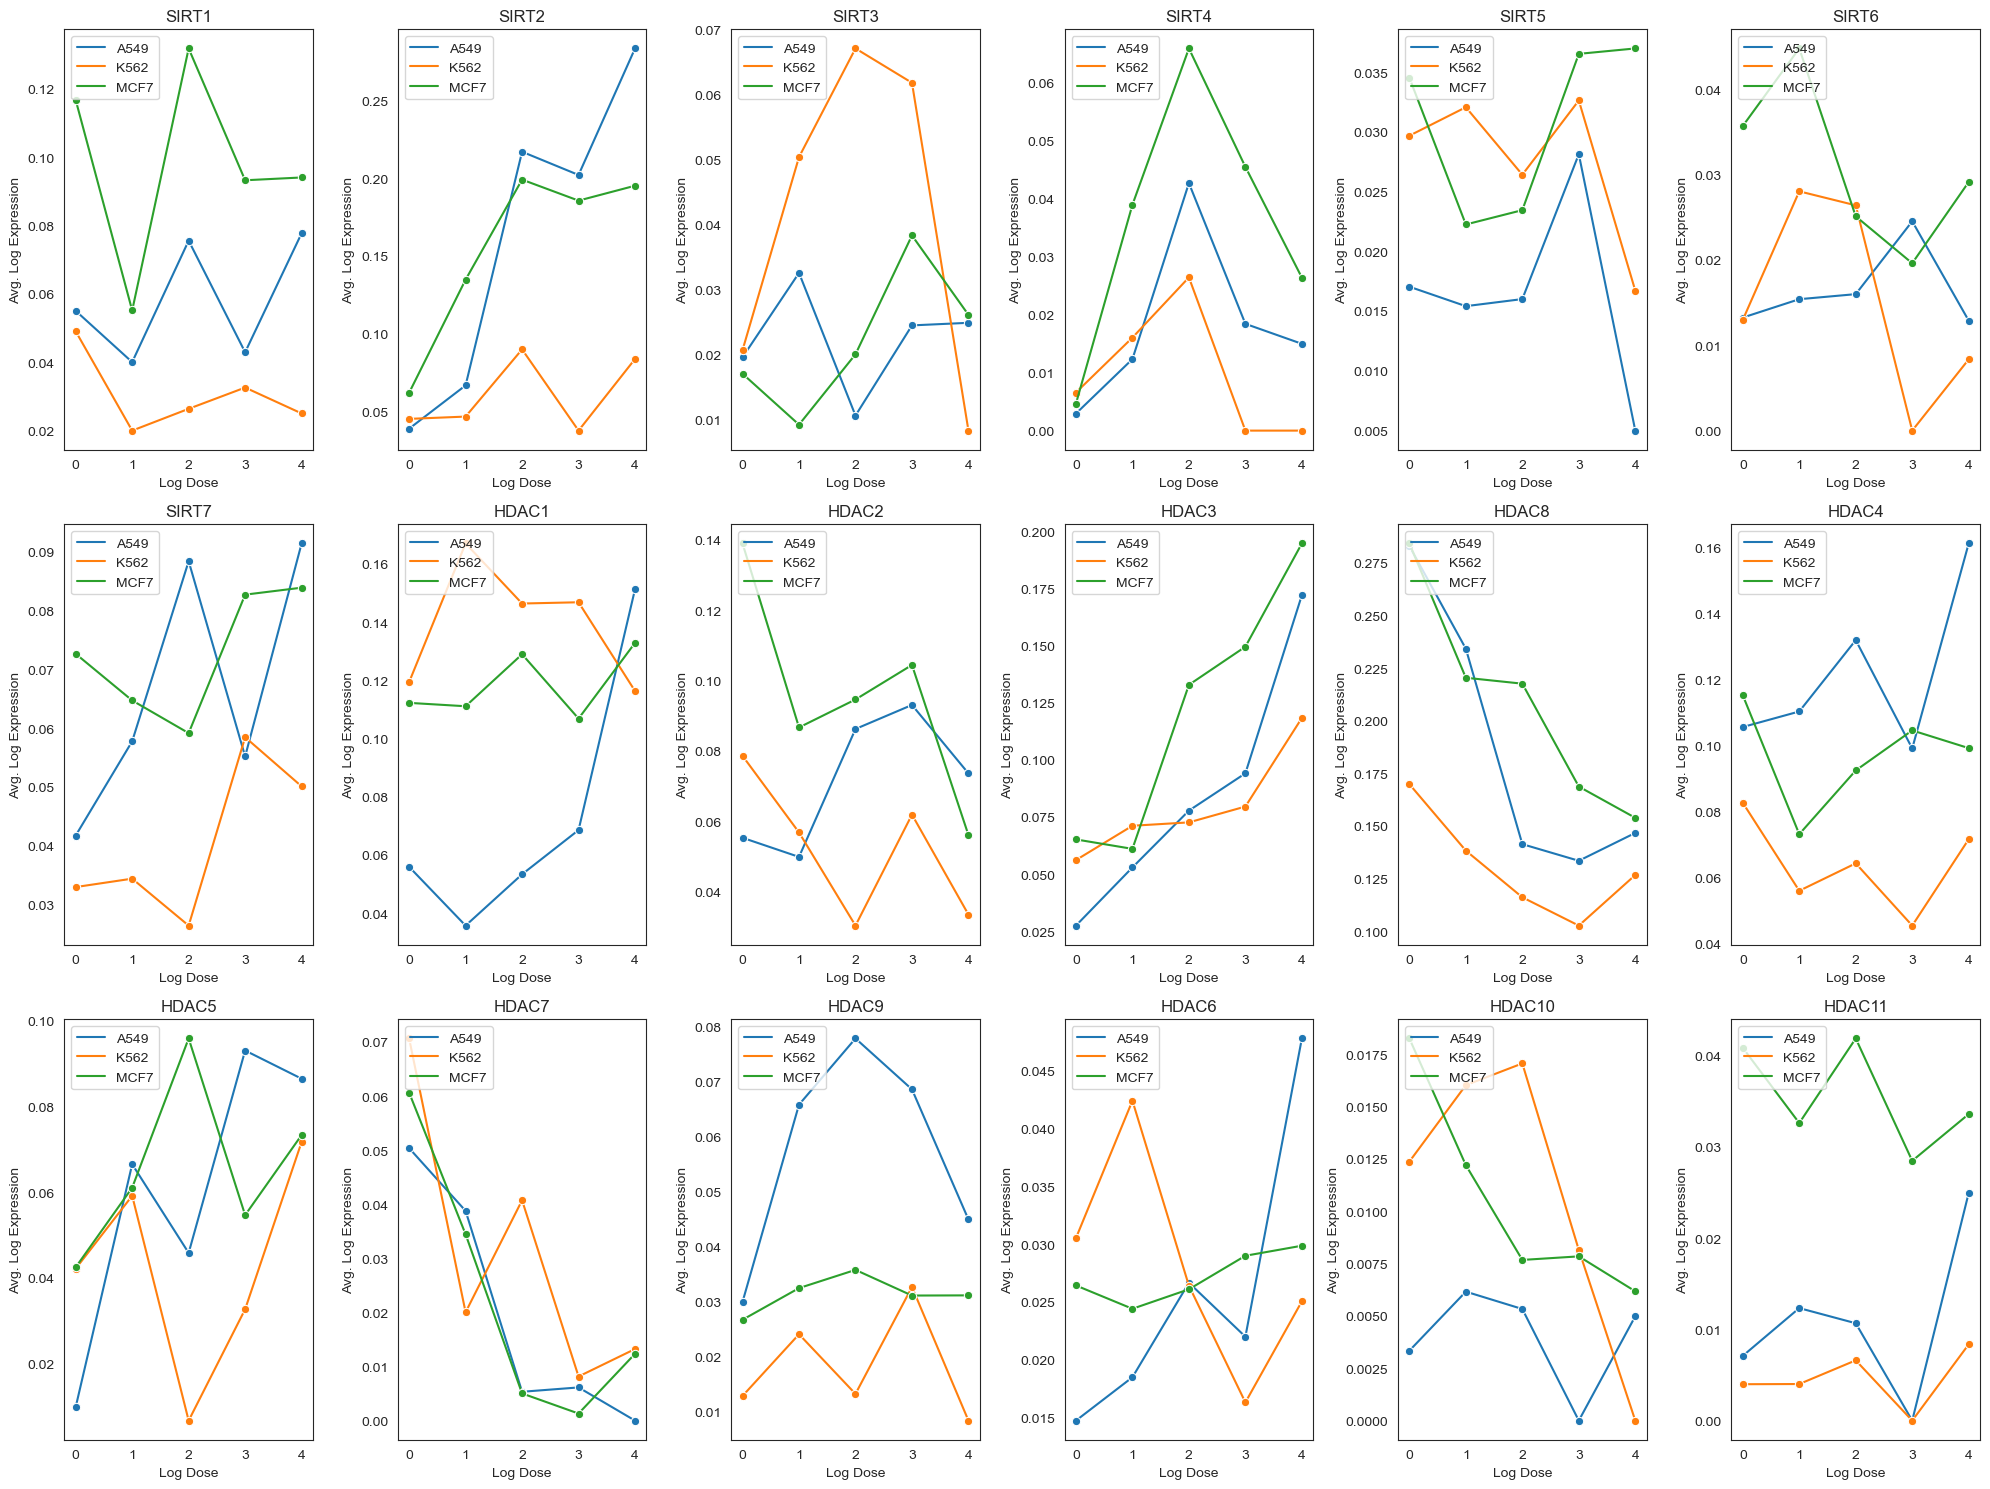

In [6]:
drug_expression_df = pd.DataFrame(hdac_data.X.toarray(), columns=hdac_data.var.index)
drug_expression_df['log10_dose'] = np.log10(hdac_data.obs['dose'].values)
drug_expression_df = drug_expression_df.replace(-np.inf, 0)
drug_expression_df['cell_type'] = hdac_data.obs['cell_type'].values
avg_log_expression = drug_expression_df.groupby(by=['cell_type', 'log10_dose']).apply(lambda x: np.log(x + 1).mean()).reset_index()
avg_log_expression = avg_log_expression.melt(id_vars=['cell_type', 'log10_dose'])
avg_log_expression.rename({'value': 'avg_log_expression'}, inplace=True, axis=1)

# Plot each of the 18 genes 
fig, ax = plt.subplots(3, 6, figsize=(20, 15))

for i, gene in enumerate(hdac_genes):
    curr_ax = ax[i // 6][i % 6]
    sns.lineplot(data=avg_log_expression[avg_log_expression.gene_name == gene], x='log10_dose', y='avg_log_expression', hue='cell_type', ax=curr_ax, marker='o')
    curr_ax.set_title(gene)
    curr_ax.set_xlabel('Log Dose')
    curr_ax.set_ylabel('Avg. Log Expression')
    curr_ax.legend(loc='upper left')

plt.tight_layout()    

Panobinostat LBH589 is biologically known to be an inhibitor of genes in the HDAC pathway. So we would expect that dosage is negatively correlated with expression levels. However, the plots above suggest that Panobinostat LBH589 sometimes increases expression levels for certain cell types. For example, in the HDAC1 gene and A549 cell type, Panobinostat LBH589 leads to an increase (on average). Could this positive correlation be due to uncontrolled confounding?

## Causal Probabilistic Program

### Model Description
In the plots above, we did not control for technical covariates (e.g., cell plate, replicate number, etc.). Here we fit a generalized linear model with a zero inflated poission likelihood to (1) account for the heavy-tailed count nature of the data, and (2) account for the fact that many genes are not expressed in a given cell.

In [16]:
class DrugPerturbationModel(PyroModule):
    def __init__(self, num_cells: int, num_genes: int, num_confounders: int):
        super().__init__()
        self.num_cells = num_cells
        self.num_genes = num_genes
        self.num_confounders = num_confounders

    def forward(self, mask: bool = False):
        propensity_weights = pyro.sample("propensity_weights", dist.Normal(0, 1).expand((self.num_confounders,)).mask(mask).to_event(1))

        # Sample regression weights for each gene
        gene_plate = pyro.plate("genes", self.num_genes, dim=-1)
        with gene_plate:
            intercept = pyro.sample("intercept", dist.Normal(0, 1))
            prior_variance = 1 / math.sqrt(self.num_confounders)
            theta_confounders = pyro.sample("theta_confounders", dist.Normal(0, prior_variance).expand((self.num_confounders,)).to_event(1)) # G x F
            theta_drug = pyro.sample("theta_drug", dist.Normal(0, 1))
            theta_confounders_drug = pyro.sample("theta_confounders_drug", dist.Normal(0, prior_variance).expand((self.num_confounders,)).to_event(1)) # G x F
            dropout_logits = pyro.sample("dropout_logits", dist.Normal(0, 1))

        # Compute likelihood
        with pyro.plate("samples", self.num_cells, dim=-2):
            # Sample treatment and confounders (remove from log_prob since we'll always conditioned on them when mask = False)
            X = pyro.sample("confounders", dist.Normal(0, 1).expand((self.num_confounders,)).to_event(1).mask(mask))
            treatment_logits = torch.einsum("...ngp,...p->...ng", X, propensity_weights)
            T = pyro.sample("drug", dist.Bernoulli(logits=treatment_logits).mask(mask))
            with gene_plate:
                confounder_variation = intercept + torch.einsum("...ngp,...gp->...ng", X, theta_confounders) # N x G
                treatment_variation = theta_drug + torch.einsum("...ngp,...ng,...gp->...ng", X, T, theta_confounders_drug) # N x G
                mean = confounder_variation + treatment_variation # N x G
                expressions = pyro.sample("gene_expression", dist.ZeroInflatedPoisson(rate=torch.exp(mean), gate_logits=dropout_logits))
        return expressions


class ConditionedDrugModel(PyroModule):
    def __init__(self, model: DrugPerturbationModel):
        super().__init__()
        self.model = model

    def forward(self, X, T, Y, **kwargs):
        with condition(data=dict(confounders=X[:, None, :], drug=T[..., None], gene_expression=Y)):
            return self.model(**kwargs)


def run_svi_inference(model, n_steps=1000, verbose=True, lr=0.03, **model_kwargs):
    guide = AutoNormal(pyro.poutine.block(model, hide_fn=lambda site: site["type"] == "sample" and site["name"] is not None and (site["name"].startswith("gene_expression") or site["name"].startswith("drug") or site["name"].startswith("confounders"))))
    elbo = pyro.infer.Trace_ELBO()(model, guide)
    # initialize parameters
    elbo(**model_kwargs)
    adam = torch.optim.Adam(elbo.parameters(), lr=lr)
    # Do gradient steps
    for step in range(1, n_steps + 1):
        adam.zero_grad()
        loss = elbo(**model_kwargs)
        loss.backward()
        adam.step()
        if (step % 250 == 0) or (step == 1) & verbose:
            print("[iteration %04d] loss: %.4f" % (step, loss))
    return guide

In [17]:
# Make data matrices
X_confounders = pd.get_dummies(hdac_data.obs[['cell_type', 'replicate', 'culture_plate', 'pcr_plate', 'well_oligo']], dtype=np.int32).reset_index(drop=True)

# Control for sequencing depth
log_umi = np.log10(hdac_data.obs['n.umi'].values)
scaled_log_umi = (log_umi - np.mean(log_umi)) / log_umi.std()
X_confounders['depth_proxy'] = scaled_log_umi

# For each drug, input log dose as a feature
T_all = pd.get_dummies(hdac_data.obs[['product_name']], dtype=np.int32).reset_index(drop=True)
T_all = T_all.mul(np.log10(hdac_data.obs['dose'].values + 1), axis=0)

# Get response for all gene expressions in HDAC pathway
Y_hdac = torch.tensor(hdac_data.X.toarray(), dtype=torch.float32)

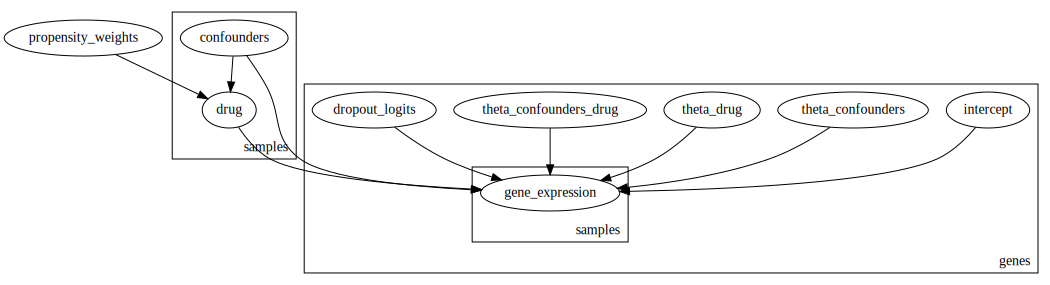

In [20]:
# Render model
model = DrugPerturbationModel(num_cells=X_confounders.shape[0], num_genes=Y_hdac.shape[1], num_confounders=X_confounders.shape[1])

# Visualize model
pyro.render_model(
    model, 
    model_args=(
        True, # so that arrows get rendered correctly
    ), 
    render_params=True, 
    render_distributions=False
)

### Reporting regression coefficients

Here we report the average treatment effect parameter `theta_drug`. Note that this parameter is harder to interpret because it represents deviations on the log transformed scale instead of the original count scale. In the next section, we will estimate average treatment effects on the original count measurement scales.

In [21]:
# We use our model to understand the conditional average treatment effect (ATE) of Panobinostat (LBH589), which is 
# a cancer drug that is in a Phase III clinical trial for acute myeloid leukaemia
drug_target = 'Panobinostat (LBH589)'
drug_control_mask = torch.tensor(hdac_data.obs['product_name'].isin(['Vehicle', drug_target]).values)
T_drug_control = torch.tensor(T_all[f'product_name_{drug_target}'].values, dtype=torch.float32)[drug_control_mask]
X_drug_control = torch.tensor(X_confounders.values[drug_control_mask], dtype=torch.float32)
Y_drug_control = Y_hdac[drug_control_mask]

# Split into training and test set
N_drug_control = X_drug_control.shape[0]
train_mask = torch.tensor(np.random.choice([True, False], size=N_drug_control, p=[0.8, 0.2]))
X_train = X_drug_control[train_mask]
T_train = T_drug_control[train_mask]
Y_train = Y_drug_control[train_mask]
X_test = X_drug_control[~train_mask]
T_test = T_drug_control[~train_mask]
Y_test = Y_drug_control[~train_mask]

In [22]:
model = ConditionedDrugModel(
        DrugPerturbationModel(num_cells=Y_train.shape[0], num_genes=Y_train.shape[1], num_confounders=X_train.shape[1])
)

guide = run_svi_inference(model, n_steps=1000, verbose=True, X=X_train, T=T_train, Y=Y_train)

[iteration 0001] loss: 132576.5938
[iteration 0250] loss: 72721.9141
[iteration 0500] loss: 72475.3750
[iteration 0750] loss: 72398.7344
[iteration 1000] loss: 72372.4141


In [23]:
unconditioned_model_test = DrugPerturbationModel(num_cells=Y_test.shape[0], num_genes=Y_test.shape[1], num_confounders=X_test.shape[1])
predictive = pyro.infer.Predictive(unconditioned_model_test, guide=guide, num_samples=500)
predictive_samples = predictive()

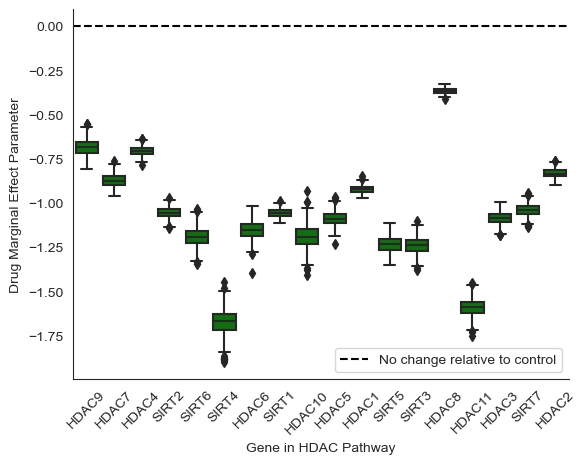

In [24]:
avg_treat_effects_by_gene = pd.DataFrame(predictive_samples['theta_drug'].squeeze(), columns=hdac_data.var.index)

sns.boxplot(data=avg_treat_effects_by_gene, color='green')
plt.axhline(0, color='black', linestyle='--', label='No change relative to control')
plt.xlabel('Gene in HDAC Pathway')
plt.xticks(rotation=45)
plt.ylabel('Drug Marginal Effect Parameter')
plt.legend()
sns.despine()

The plot above suggests that Panobinostat LBH589 lowers the expression levels of all genes in the HDAC pathway, which is consistent with its known biological behavior as an inhibitor. 

### Predictions on unseen cells

As we see below, our predictions of gene expressions are quite poor. However, this is not very suprising because we are using a linear model, and not conditioning on more cell and gene features.

In [25]:
test_avg = predictive_samples['gene_expression'].mean(dim=0)
test_q05 =torch.quantile(predictive_samples['gene_expression'], .05, dim=0)
test_q50 = torch.quantile(predictive_samples['gene_expression'], .5, dim=0)
test_q95 = torch.quantile(predictive_samples['gene_expression'], .95, dim=0)

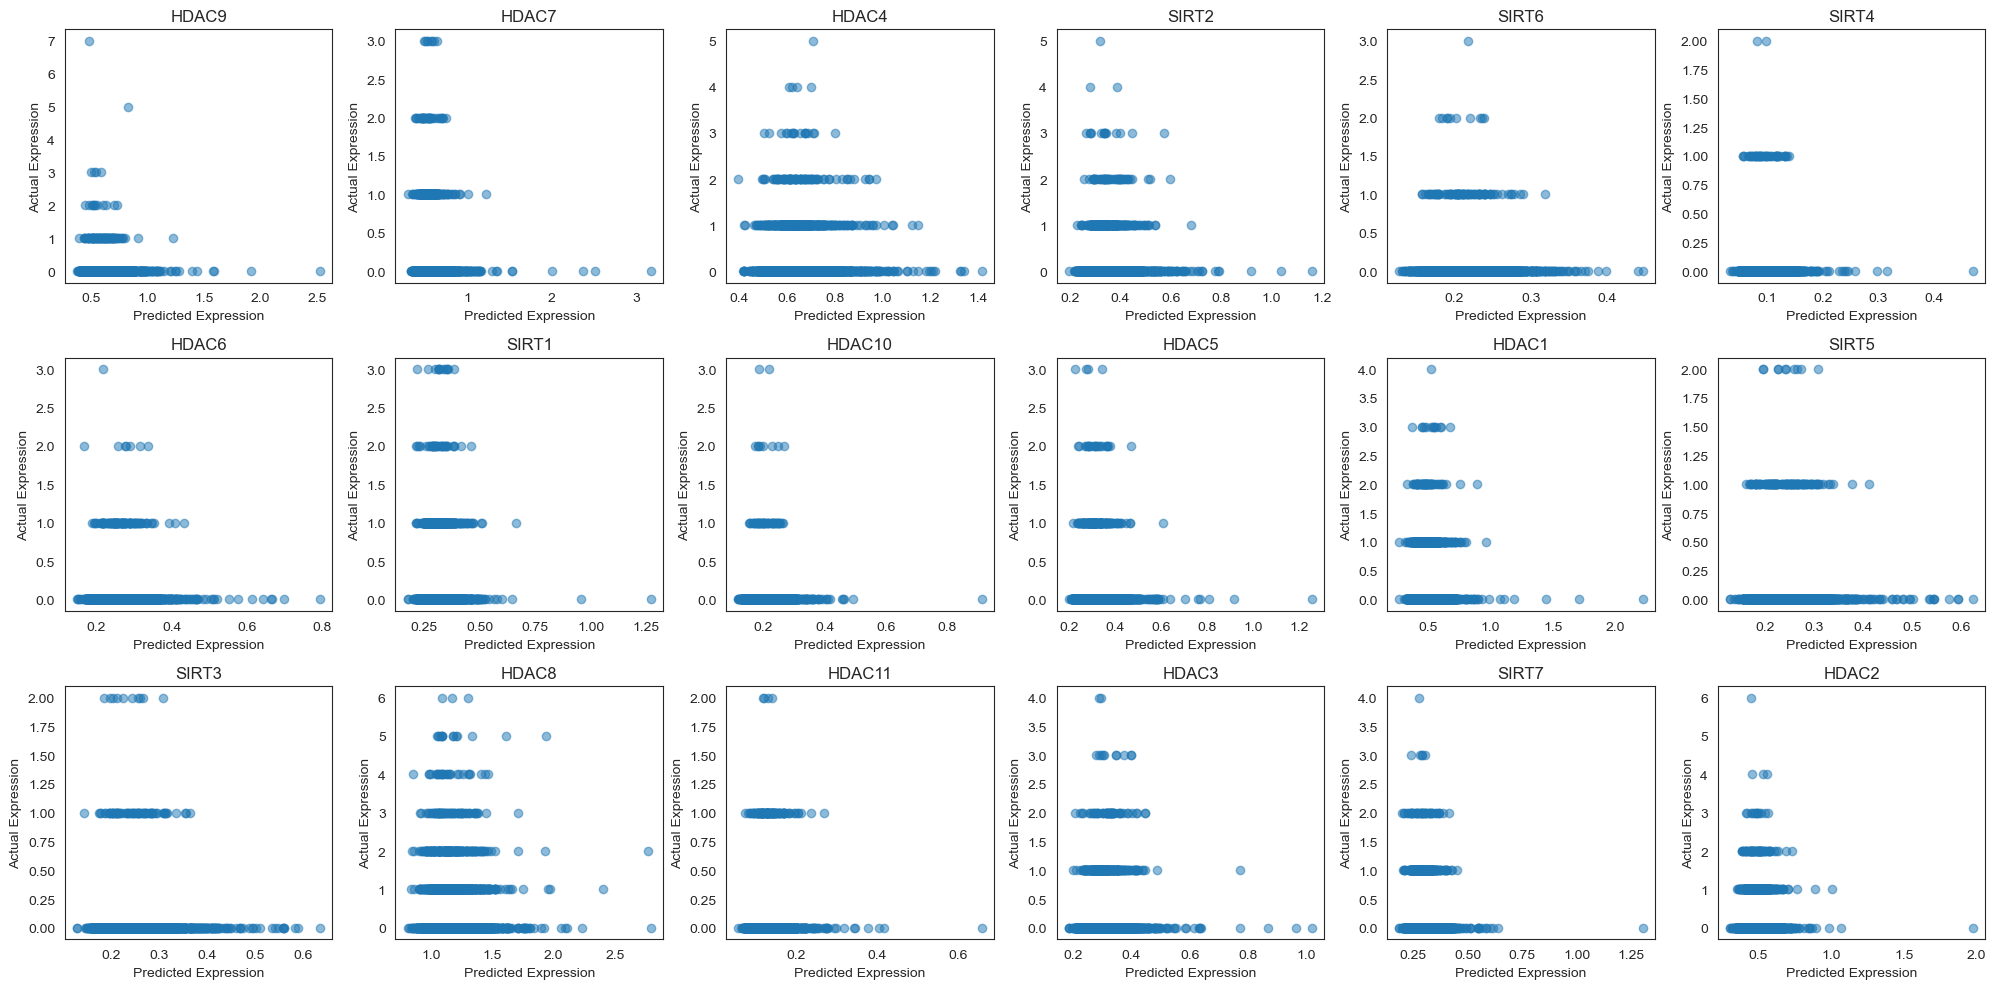

In [26]:
# Compare posterior mean predictions across 18 genes 
fig, ax = plt.subplots(3, 6, figsize=(20, 10))

for i, gene in enumerate(hdac_data.var.index):
    curr_ax = ax[i // 6][i % 6]
    curr_ax.scatter(test_avg[:, i], Y_test[:, i], alpha=0.5)
    curr_ax.set_title(gene)
    curr_ax.set_xlabel('Predicted Expression')
    curr_ax.set_ylabel('Actual Expression')

plt.tight_layout()

## Computing causal queries

We impute counterfactuals for each cell and gene to compute causal summaries of interest. Specifically, let $Y_{nj}(T)$ denote the expression potential outcome for dosage $T$, cell $n$, and gene $j$, where $T \in \{0, 10^1, 10^2, 10^3, 10^4\}$. For cell $n$, we only observe the potential outcome $Y_{nj}(\cdot)$ at a particular dosage $T_n$. So we impute the potential outcome $Y_{nj}(T)$ for all $T \neq T_n$. Of course, since we only observe each cell once, there is non-trivial uncertainity in the imputed potential outcomes. However, we can reduce this uncertainty by aggregating the estimated potential outcomes into summaries of interest. For example, we can estimate the average treatment effect (ATE) at dose $T > 0$ for gene $j$ as follows:

$$
\widehat{\text{ATE}}_j(T) = \frac{1}{N} \sum_{n=1}^N \tilde{Y}_{nj}(T) - \tilde{Y}_{nj}(0)
$$

where $N$ is the number of cells,

$$
\tilde{Y}_{nj}(T^{\prime}) = \begin{cases}
\hat{Y}_{nj}(T^{\prime}) & \text{if } T^{\prime} \neq T_n \\
Y_{nj} & \text{if } T^{\prime} = T_n,
\end{cases}
$$

$\hat{Y}_{nj}(T^{\prime})$ is the imputed counterfactual, and $Y_{nj}$ is the actual observed expression level. We can also estimate the conditional average treatment effect (CATE) in a similar fashion. For example, we can compute the conditional average treatment effect of the drug on cell type $c$ as follows:

$$
\widehat{\text{CATE}}_{j}(T, c) = \frac{1}{N_c} \sum_{n=1}^N [\tilde{Y}_{nj}(T) - \tilde{Y}_{nj}(0)]I(\text{cell type}_n = c)
$$

where $N_c$ is the number of cells of cell type $c$.

### Imputing potential outcomes

To impute potential outcomes, we use our fitted Bayesian model and ChiRho's `MultiWorldCounterfactual` and `do` operators.

In [30]:
# Here we impute potential outcomes for each datapoint at a specified dosage level
class ImputePotentialOutcome(pyro.nn.PyroModule):
    def __init__(self, conditioned_model: ConditionedDrugModel):
        super().__init__()
        self.conditioned_model = conditioned_model

    def forward(self, dose_level: float, X: torch.tensor, T: torch.tensor, Y: torch.tensor, dose_epsilon: float = .2):
        T_level = dose_level * torch.ones(X.shape[0])
        with MultiWorldCounterfactual(), do(actions={"drug": T_level[..., None]}):
            expressions = self.conditioned_model(X, T, Y)
            expressions_cf = gather(expressions, IndexSet(drug={1}))
            expressions_f = gather(expressions, IndexSet(drug={0}))
            obs_dose_mask = torch.isclose(T[..., None], torch.tensor(dose_level), atol=dose_epsilon)
            # Use factual value of potential outcome if observed at dose; otherwise impute using
            # counterfactual value
            expressions_po = torch.where(obs_dose_mask, expressions_f, expressions_cf)
            pyro.deterministic("expressions_po", expressions_po.squeeze())

In [31]:
po_impute_model = ImputePotentialOutcome(ConditionedDrugModel(
        DrugPerturbationModel(num_cells=Y_drug_control.shape[0], num_genes=Y_drug_control.shape[1], num_confounders=X_train.shape[1])
))

po_impute_predictive = pyro.infer.Predictive(po_impute_model, guide=guide, num_samples=500, parallel=True)

# Impute confounterfactuals at each log dose level
po_0_prediction = po_impute_predictive(0., X_drug_control, T_drug_control, Y_drug_control)['expressions_po'].squeeze()
po_1_prediction = po_impute_predictive(1., X_drug_control, T_drug_control, Y_drug_control)['expressions_po'].squeeze()
po_2_prediction = po_impute_predictive(2., X_drug_control, T_drug_control, Y_drug_control)['expressions_po'].squeeze()
po_3_prediction = po_impute_predictive(3., X_drug_control, T_drug_control, Y_drug_control)['expressions_po'].squeeze()
po_4_prediction = po_impute_predictive(4., X_drug_control, T_drug_control, Y_drug_control)['expressions_po'].squeeze()

### Causal Query: Average treatment effect (ATE)

In [32]:
def conditional_avg_treatment(po_t, po_0, mask):
    po_t = po_t[:, mask, :]
    po_0 = po_0[:, mask, :]
    cate = (po_t - po_0).mean(dim=1) # average over datapoints at dim=1
    return cate # number posterior samples x number genes

def average_treatment_effect(po_t, po_0):
    mask = torch.tensor([True] * po_t.shape[1])
    return conditional_avg_treatment(po_t, po_0, mask)

In [33]:
ates = [
    average_treatment_effect(po_1_prediction, po_0_prediction),
    average_treatment_effect(po_2_prediction, po_0_prediction),
    average_treatment_effect(po_3_prediction, po_0_prediction),
    average_treatment_effect(po_4_prediction, po_0_prediction),       
]

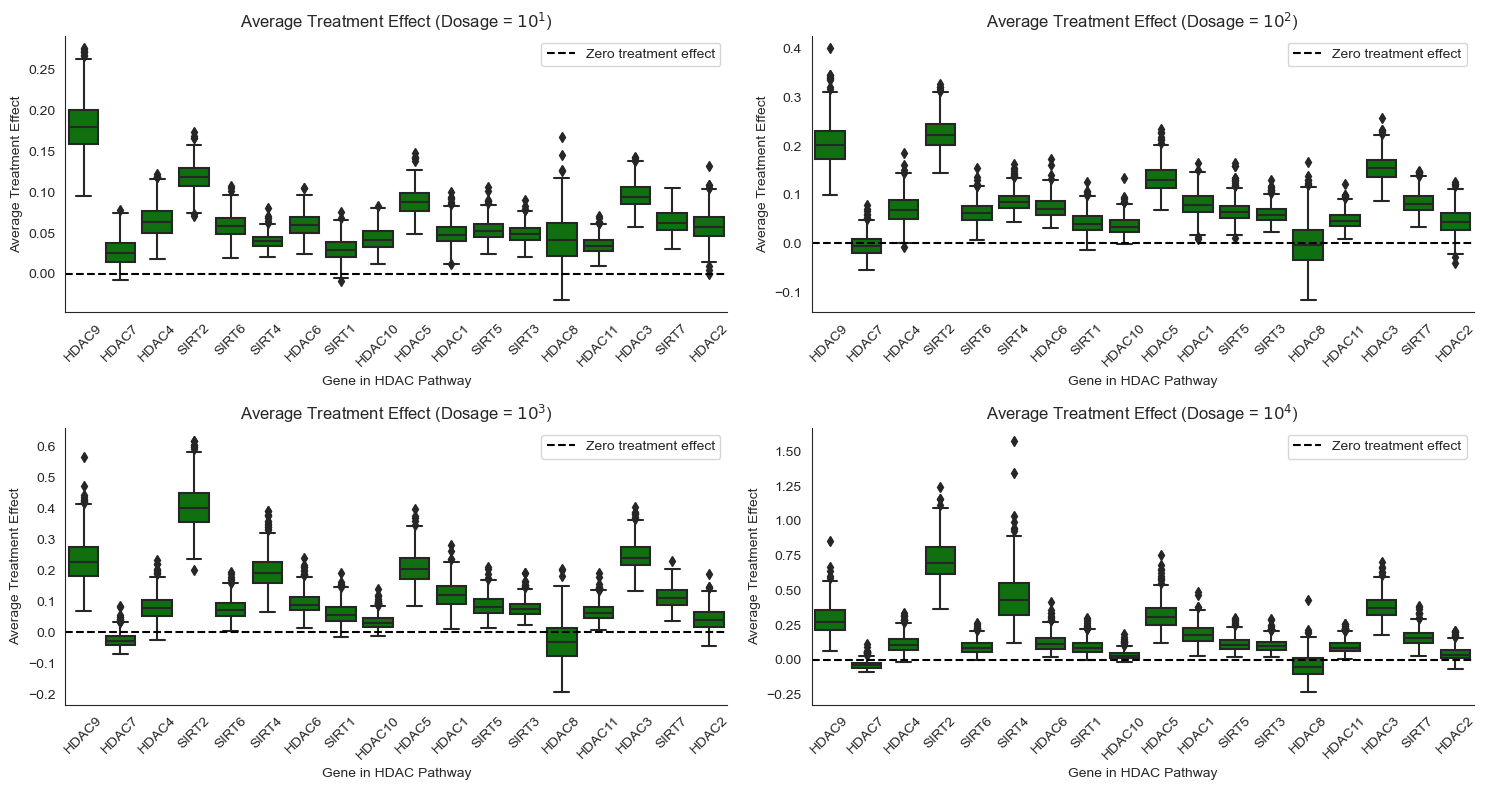

In [34]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))

for i, dose_level in enumerate([1, 2, 3, 4]):
    curr_ax = ax[i // 2][i % 2]
    sns.boxplot(pd.DataFrame(ates[i], columns=hdac_data.var.index), color='green', ax=curr_ax)
    curr_ax.set_title(f'Average Treatment Effect (Dosage = $10^{dose_level}$)')
    curr_ax.axhline(0, color='black', linestyle='--', label='Zero treatment effect')
    curr_ax.set_xlabel('Gene in HDAC Pathway')
    for tick in curr_ax.get_xticklabels():
        tick.set_rotation(45)
    curr_ax.set_ylabel('Average Treatment Effect')
    curr_ax.legend()
    sns.despine()

plt.tight_layout() 


The plot above provides the uncertainity across the average treatment effect for each gene. The upper and lower lines on each boxplot form a 50% credible interval for the average treatment effect.

### Causal Query: Conditional average treatment effect (CATE)

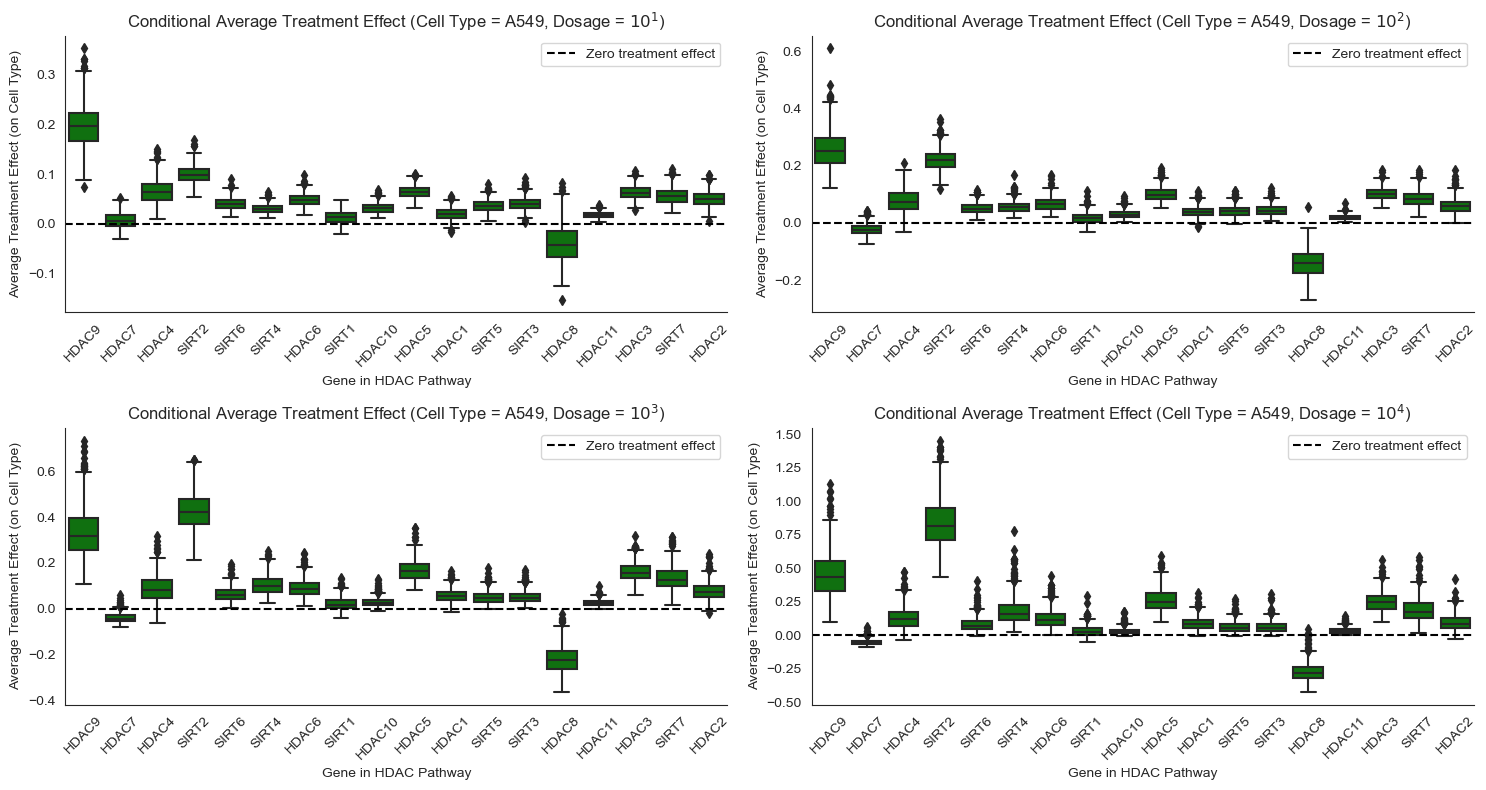

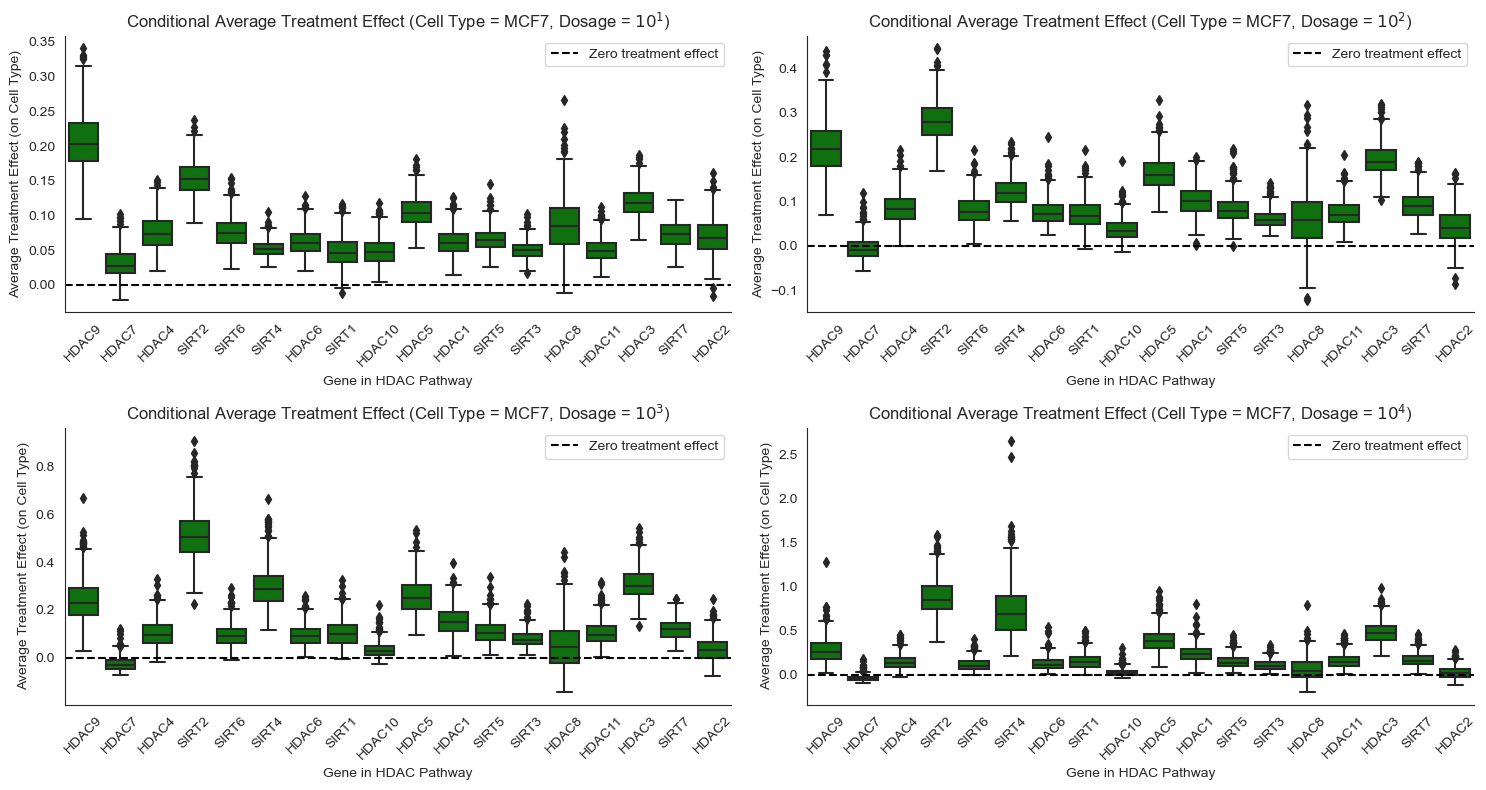

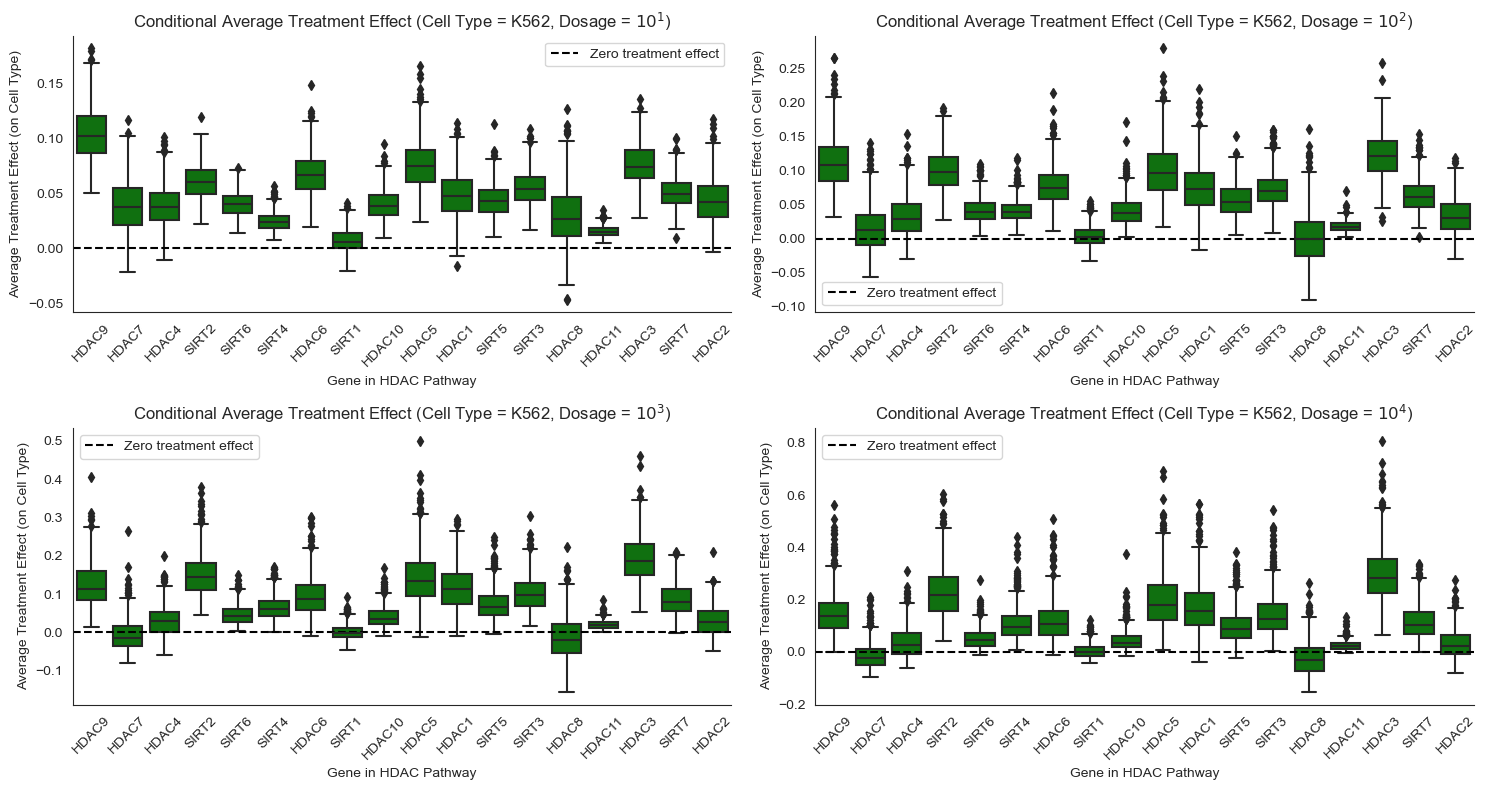

In [39]:
for cell_type in ['A549', 'MCF7', 'K562']:
    cell_type_mask = torch.tensor(hdac_data.obs['cell_type'] == cell_type)[drug_control_mask]
    ates = [
        conditional_avg_treatment(po_1_prediction, po_0_prediction, cell_type_mask),
        conditional_avg_treatment(po_2_prediction, po_0_prediction, cell_type_mask),
        conditional_avg_treatment(po_3_prediction, po_0_prediction, cell_type_mask),
        conditional_avg_treatment(po_4_prediction, po_0_prediction, cell_type_mask),
    ]

    fig, ax = plt.subplots(2, 2, figsize=(15, 8))

    for i, dose_level in enumerate([1, 2, 3, 4]):
        curr_ax = ax[i // 2][i % 2]
        sns.boxplot(pd.DataFrame(ates[i], columns=hdac_data.var.index), color='green', ax=curr_ax)
        curr_ax.set_title(f'Conditional Average Treatment Effect (Cell Type = {cell_type}, Dosage = $10^{dose_level}$)')
        curr_ax.axhline(0, color='black', linestyle='--', label='Zero treatment effect')
        curr_ax.set_xlabel('Gene in HDAC Pathway')
        for tick in curr_ax.get_xticklabels():
            tick.set_rotation(45)
        curr_ax.set_ylabel('Average Treatment Effect (on Cell Type)')
        curr_ax.legend()
        sns.despine()

    plt.tight_layout() 

# References

1. https://www.science.org/doi/10.1126/science.aax6234
2. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3056563/#:~:text=Histone%20deacetylase%20(HDAC)%20inhibitors%20are,cycle%20arrest%20in%20cancer%20cells.
3. https://www.frontiersin.org/articles/10.3389/fcell.2020.576946/full
4. https://www.genenames.org/data/genegroup/#!/group/937